In [11]:
using Plots
using PLAYA
using Statistics
using UnicodeFun # to_latex
using DifferentialEquations
using DiffEqSensitivity
using ODEInterfaceDiffEq # radau
using Catalyst

# Setup

In [2]:
# parse BOLOS output
bolos_interpolations = parse_bolos_output("../assets/air-kinetics-bolos.dat")

Loaded Mean energy from BOLOS file
Loaded Mobility *N from BOLOS file
Loaded Diffusion coefficient *N from BOLOS file
Loaded N2O->None from BOLOS file
Loaded NO->None from BOLOS file
Loaded NO->None from BOLOS file
Loaded NO->None from BOLOS file
Loaded O2(a1)->None from BOLOS file
Loaded O->None from BOLOS file
Loaded N2->None from BOLOS file
Loaded N->None from BOLOS file
Loaded O3->None from BOLOS file
Loaded O2->None from BOLOS file
Loaded N2O->N2O^- from BOLOS file
Loaded N2O->N2O^+ from BOLOS file
Loaded N2O->N2O(V2)(0.073eV) from BOLOS file
Loaded N2O->N2O(V3)(0.159eV) from BOLOS file
Loaded N2O->N2O(V1)(0.276eV) from BOLOS file
Loaded N2O->N2O(e1)(4.05eV) from BOLOS file
Loaded N2O->N2O(e2)(8.5eV) from BOLOS file
Loaded N2O->N2O(e3)(9.6eV) from BOLOS file
Loaded NO->O^-+N from BOLOS file
Loaded NO->NO(ionization) from BOLOS file
Loaded NO->NO^+ from BOLOS file
Loaded NO->N+O^+ from BOLOS file
Loaded NO->N^++O from BOLOS file
Loaded NO->NO++ from BOLOS file
Loaded NO->NO(a4PI) f

Dict{AbstractString,Interpolations.GriddedInterpolation{Float64,1,Float64,Interpolations.Gridded{Interpolations.Linear},Tuple{Array{Float64,1}}}} with 87 entries:
  "NO->NO(A2SIGMA+)"      => 200-element interpolate((::Array{Float64,1},), ::A…
  "N2->N2(v3)"            => 200-element interpolate((::Array{Float64,1},), ::A…
  "NO->NO(D2SIGMA+)"      => 200-element interpolate((::Array{Float64,1},), ::A…
  "N->N^+"                => 200-element interpolate((::Array{Float64,1},), ::A…
  "O2(a1)->None"          => 200-element interpolate((::Array{Float64,1},), ::A…
  "N2->N2(v6)"            => 200-element interpolate((::Array{Float64,1},), ::A…
  "N2->N2(v4)"            => 200-element interpolate((::Array{Float64,1},), ::A…
  "O2->O2(v1res)"         => 200-element interpolate((::Array{Float64,1},), ::A…
  "O2(a1)->O2^+"          => 200-element interpolate((::Array{Float64,1},), ::A…
  "O2->O^-+O"             => 200-element interpolate((::Array{Float64,1},), ::A…
  "O->O(1D)"              =

In [3]:
EN = 200. # Townsend
Tgas = 300.
Te = bolos_interpolations["Mean energy"](EN) * 1.1604505e4  # Temperature of electrons in K
dTion  = 2.0e0 / ( 3.0e0 * 1.3807e-16 ) * 1.6605e-24 * ( 1.0e-17 * EN )^2
TionN  = Tgas + dTion * 14.0e0 * 8.0e19^2
TionN2 = Tgas + dTion * 28.0e0 * 4.1e19^2
TionN3 = Tgas + dTion * 42.0e0 * 6.1e19^2
TionN4 = Tgas + dTion * 56.0e0 * 7.0e19^2
TeffN  = ( TionN  + 0.5e0 * Tgas ) / ( 1.0e0 + 0.5e0 )
TeffN2 = ( TionN2 + 1.0e0 * Tgas ) / ( 1.0e0 + 1.0e0 )
TeffN3 = ( TionN3 + 1.5e0 * Tgas ) / ( 1.0e0 + 1.5e0 )
TeffN4 = ( TionN4 + 2.0e0 * Tgas ) / ( 1.0e0 + 2.0e0 )
Teff3Q = 46.501347e-27*((1.87e-4*(1.0e5/(273.0*1.38064e-23))*( 1.0e-21 * EN ))^2)/(3.0e0*1.38064e-23) + Tgas

globals = Dict{Symbol, Any}([
                :E => EN,
                :Te => Te,
                :Tgas => Tgas,
                :dTion   => dTion,
                :TionN   => TionN,
                :TionN2  => TionN2,
                :TionN3  => TionN3,
                :TionN4  => TionN4,
                :TeffN   => TeffN,
                :TeffN2  => TeffN2,
                :TeffN3  => TeffN3,
                :TeffN4  => TeffN4,
                :Teff3Q  => Teff3Q,
               ])

# create functions that will get evaluated to rates
globals[:BOLOS] = (id, env) -> bolos_interpolations[id](env[:E])

println(globals)

Dict{Symbol,Any}(:TionN2 => 1809.503179546607,:dTion => 3.2070688781053097e-38,:TeffN3 => 2304.828553632216,:Te => 63815.573943526564,:TeffN4 => 3233.39900050699,:E => 200.0,:TionN4 => 9100.19700152097,:TeffN => 2215.689143188238,:Teff3Q => 1405.4034963438025,:TionN3 => 5312.07138408054,:BOLOS => var"#1#2"(),:TionN => 3173.5337147823575,:TeffN2 => 1054.7515897733035,:Tgas => 300.0)


In [4]:
# replace stuff so it is Catalyst-compliant
replacements = [
                "^+" => to_latex("^+"),
                "^-" => to_latex("^-"),
                "(" => to_latex("\\llcorner"),
                ")" => to_latex("\\lrcorner"),
                "4.5eV" => to_latex("4°5eV"),
                "`" => to_latex("\\tilde"),
                "=>" => "-->",
    ]

7-element Array{Pair{String,String},1}:
    "^+" => "⁺"
    "^-" => "⁻"
     "(" => "⌞"
     ")" => "⌟"
 "4.5eV" => "4°5eV"
     "`" => "̃"
    "=>" => "-->"

In [5]:
# parse the reaction file
(rs, ps) = parse_reactions("../assets/air-kinetics.reactions", globals; to_replace=replacements)

4.939058174439241e-17 *1e6
1.9911141532416576e-16 *1e6
1.797743750895955e-16 *1e6
7.067316923201697e-16 *1e6
5.767108659083016e-16 *1e6
1.784256590959922e-16 *1e6
1.424435933689807e-16 *1e6
3.819969134318789e-16 *1e6
1.8163166126193177e-16 *1e6
1.8730503987046348e-16 *1e6
4.057625093885372e-16 *1e6
7.504453417455757e-16 *1e6
1.7646814595265084e-16 *1e6
4.981545523119259e-16 *1e6
1.1505931286663538e-15 *1e6
3.972835714775334e-15 *1e6
1.3639781504135325e-17 *1e6
1.1505931286663538e-15 *1e6
2.366727790024083e-15 *1e6
1.6630317338546856e-16 *1e6
1.1096030276599076e-16 *1e6
2.8493172592219414e-16 *1e6
9.709953961429102e-17 *1e6
7.070913161706952e-16 *1e6
1.951697397109282e-16 *1e6
6.910712391498831e-16 *1e6
5.351699934483668e-16 *1e6
4.80874806454691e-18 *1e6
9.111030100148469e-19  *1e6
2.217650170397427e-19  *1e6
3.442467740972708e-16 *1e6
1.8432516749487616e-14 *1e6
4.1379529557079665e-17 *1e6
2.766759847456786e-17 *1e6
3.1316031291510663e-16 *1e6
1.3916818395449048e-16 *1e6
1.72739962435

(ReactionSystem(Reaction[Reaction{Variable,Int64}(p1, Operation[e(t), N2(t)], Operation[e(t), N2⌞A3⌟(t)], [1, 1], [1, 1], Pair{Variable,Int64}[N2 => -1, N2⌞A3⌟ => 1], false), Reaction{Variable,Int64}(p2, Operation[e(t), N2(t)], Operation[e(t), N2⌞A3⌟(t)], [1, 1], [1, 1], Pair{Variable,Int64}[N2 => -1, N2⌞A3⌟ => 1], false), Reaction{Variable,Int64}(p3, Operation[e(t), N2(t)], Operation[e(t), N2⌞A3⌟(t)], [1, 1], [1, 1], Pair{Variable,Int64}[N2 => -1, N2⌞A3⌟ => 1], false), Reaction{Variable,Int64}(p4, Operation[e(t), N2(t)], Operation[e(t), N2⌞B3⌟(t)], [1, 1], [1, 1], Pair{Variable,Int64}[N2⌞B3⌟ => 1, N2 => -1], false), Reaction{Variable,Int64}(p5, Operation[e(t), N2(t)], Operation[e(t), N2⌞B3⌟(t)], [1, 1], [1, 1], Pair{Variable,Int64}[N2⌞B3⌟ => 1, N2 => -1], false), Reaction{Variable,Int64}(p6, Operation[e(t), N2(t)], Operation[e(t), N2⌞B3⌟(t)], [1, 1], [1, 1], Pair{Variable,Int64}[N2⌞B3⌟ => 1, N2 => -1], false), Reaction{Variable,Int64}(p7, Operation[e(t), N2(t)], Operation[e(t), N2⌞ã1⌟

# Create the system of ODEs

In [6]:
# initial conditions
n_gas = 2.5e19
conc = Dict([
        "e" => 1e12,
        "N2" => 0.8*n_gas,
        "O2" => 0.2*n_gas,
        "ANY_NEUTRAL" => n_gas
        ])
u0 = [ get(conc, string(s), 0.) for s in species(rs) ]
tspan = (0., 1e-4)

odesys = convert(ODESystem, rs)

# Keep electrons and neutrals fixed
keep_fixed!(odesys, "e")
keep_fixed!(odesys, "ANY_NEUTRAL")

Equation(derivative(ANY_NEUTRAL(t), t), identity(0))

In [7]:
prob = ODEProblem(odesys, u0, tspan, ps)

print("Solving....")
sol = solve(prob, Rodas5(), reltol=1e-8, abstol=1e-8)

Solving....

retcode: Success
Interpolation: 3rd order Hermite
t: 2147-element Array{Float64,1}:
 0.0
 1.0202446544326312e-12
 1.4678438319125098e-12
 2.270586066509199e-12
 3.073328301105889e-12
 4.020550346918904e-12
 5.046819543583007e-12
 6.197486170839228e-12
 7.458416258628852e-12
 8.846841665838558e-12
 1.0363115467304404e-11
 1.2016455697624176e-11
 1.3811400849293754e-11
 ⋮
 9.209490338921626e-5
 9.281764978729468e-5
 9.355243986615576e-5
 9.429971950428508e-5
 9.50599593190367e-5
 9.583365358444193e-5
 9.662132634833064e-5
 9.742353083715435e-5
 9.824085019969765e-5
 9.907390249682423e-5
 9.992334183759017e-5
 0.0001
u: 2147-element Array{Array{Float64,1},1}:
 [1.0e12, 2.0e19, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0e18, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0e12, 1.999999993287035e19, 8.748002688675764e9, 2.9796797258454422e10, 1.440678465107835e10, 3.818553000691163e9, 8.279542184145716e9, 8.279429264484044e9, 4.999999965289374e18, 3.8282453814092703e9  …  28471.4398178

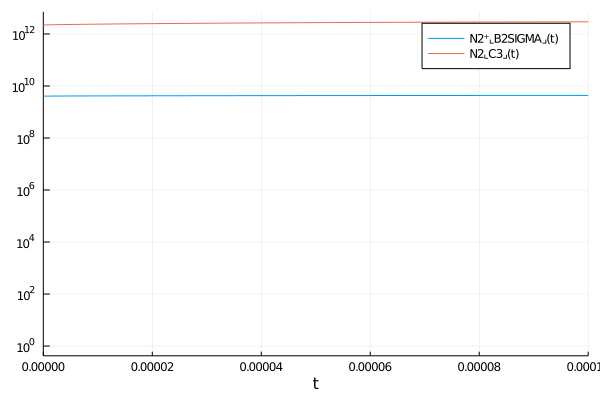

In [8]:
plot(sol, vars=(0, 22), yscale=:log10, ylims=[1,3e12])
plot!(sol, vars=(0, 6))

# Sensitivity analysis

Based on [DifferentialEquations tutorial](https://diffeq.sciml.ai/stable/analysis/global_sensitivity/)

In [12]:
f1 = function (p)
  prob1 = remake(prob;p=p)
  sol = solve(prob1, radau();
              saveat=range(tspan[2]/10., stop=tspan[2], length=100),
              reltol=1e-8,
              abstol=1e-8,
             )
  mean(sol[6,:])/mean(sol[22,:])
end

bounds = [ [0.5*i, 1.5*i] for i in ps ]
m = gsa(f1, Morris(total_num_trajectory=1000, num_trajectory=150), bounds)

 EXIT OF RADAU AT X=        0.1000E-03
  STEP SIZE T0O SMALL, H=   1.3552527156068805E-020
 EXIT OF RADAU AT X=        0.1000E-03
  STEP SIZE T0O SMALL, H=   1.3552527156068805E-020


┌ Warning: Step size went too small.
└ @ ODEInterfaceDiffEq /home/tungli/.julia/packages/ODEInterfaceDiffEq/Z8m4p/src/solve.jl:172
┌ Warning: Step size went too small.
└ @ ODEInterfaceDiffEq /home/tungli/.julia/packages/ODEInterfaceDiffEq/Z8m4p/src/solve.jl:172


 EXIT OF RADAU AT X=        0.1000E-03
  STEP SIZE T0O SMALL, H=   1.3552527156068805E-020
 EXIT OF RADAU AT X=        0.1000E-03
  STEP SIZE T0O SMALL, H=   1.3552527156068805E-020


┌ Warning: Step size went too small.
└ @ ODEInterfaceDiffEq /home/tungli/.julia/packages/ODEInterfaceDiffEq/Z8m4p/src/solve.jl:172
┌ Warning: Step size went too small.
└ @ ODEInterfaceDiffEq /home/tungli/.julia/packages/ODEInterfaceDiffEq/Z8m4p/src/solve.jl:172


 EXIT OF RADAU AT X=        0.1000E-03
  STEP SIZE T0O SMALL, H=   1.3552527156068805E-020
 EXIT OF RADAU AT X=        0.1000E-03
  STEP SIZE T0O SMALL, H=   1.3552527156068805E-020


┌ Warning: Step size went too small.
└ @ ODEInterfaceDiffEq /home/tungli/.julia/packages/ODEInterfaceDiffEq/Z8m4p/src/solve.jl:172
┌ Warning: Step size went too small.
└ @ ODEInterfaceDiffEq /home/tungli/.julia/packages/ODEInterfaceDiffEq/Z8m4p/src/solve.jl:172


 EXIT OF RADAU AT X=        0.1000E-03
  STEP SIZE T0O SMALL, H=   1.3552527156068805E-020
 EXIT OF RADAU AT X=        0.1000E-03
  STEP SIZE T0O SMALL, H=   1.3552527156068805E-020


┌ Warning: Step size went too small.
└ @ ODEInterfaceDiffEq /home/tungli/.julia/packages/ODEInterfaceDiffEq/Z8m4p/src/solve.jl:172
┌ Warning: Step size went too small.
└ @ ODEInterfaceDiffEq /home/tungli/.julia/packages/ODEInterfaceDiffEq/Z8m4p/src/solve.jl:172


 EXIT OF RADAU AT X=        0.1000E-03
  STEP SIZE T0O SMALL, H=   1.3552527156068805E-020
 EXIT OF RADAU AT X=        0.1000E-03
  STEP SIZE T0O SMALL, H=   1.3552527156068805E-020


┌ Warning: Step size went too small.
└ @ ODEInterfaceDiffEq /home/tungli/.julia/packages/ODEInterfaceDiffEq/Z8m4p/src/solve.jl:172
┌ Warning: Step size went too small.
└ @ ODEInterfaceDiffEq /home/tungli/.julia/packages/ODEInterfaceDiffEq/Z8m4p/src/solve.jl:172


 EXIT OF RADAU AT X=        0.1000E-03
  STEP SIZE T0O SMALL, H=   1.3552527156068805E-020
 EXIT OF RADAU AT X=        0.1000E-03
  STEP SIZE T0O SMALL, H=   1.3552527156068805E-020


┌ Warning: Step size went too small.
└ @ ODEInterfaceDiffEq /home/tungli/.julia/packages/ODEInterfaceDiffEq/Z8m4p/src/solve.jl:172
┌ Warning: Step size went too small.
└ @ ODEInterfaceDiffEq /home/tungli/.julia/packages/ODEInterfaceDiffEq/Z8m4p/src/solve.jl:172


 EXIT OF RADAU AT X=        0.1000E-03
  STEP SIZE T0O SMALL, H=   1.3552527156068805E-020
 EXIT OF RADAU AT X=        0.1000E-03
  STEP SIZE T0O SMALL, H=   1.3552527156068805E-020


┌ Warning: Step size went too small.
└ @ ODEInterfaceDiffEq /home/tungli/.julia/packages/ODEInterfaceDiffEq/Z8m4p/src/solve.jl:172
┌ Warning: Step size went too small.
└ @ ODEInterfaceDiffEq /home/tungli/.julia/packages/ODEInterfaceDiffEq/Z8m4p/src/solve.jl:172


 EXIT OF RADAU AT X=        0.1000E-03
  STEP SIZE T0O SMALL, H=   1.3552527156068805E-020
 EXIT OF RADAU AT X=        0.1000E-03
  STEP SIZE T0O SMALL, H=   1.3552527156068805E-020


┌ Warning: Step size went too small.
└ @ ODEInterfaceDiffEq /home/tungli/.julia/packages/ODEInterfaceDiffEq/Z8m4p/src/solve.jl:172
┌ Warning: Step size went too small.
└ @ ODEInterfaceDiffEq /home/tungli/.julia/packages/ODEInterfaceDiffEq/Z8m4p/src/solve.jl:172


 EXIT OF RADAU AT X=        0.1000E-03
  STEP SIZE T0O SMALL, H=   1.3552527156068805E-020
 EXIT OF RADAU AT X=        0.1000E-03
  STEP SIZE T0O SMALL, H=   1.3552527156068805E-020


┌ Warning: Step size went too small.
└ @ ODEInterfaceDiffEq /home/tungli/.julia/packages/ODEInterfaceDiffEq/Z8m4p/src/solve.jl:172
┌ Warning: Step size went too small.
└ @ ODEInterfaceDiffEq /home/tungli/.julia/packages/ODEInterfaceDiffEq/Z8m4p/src/solve.jl:172


 EXIT OF RADAU AT X=        0.1000E-03
  STEP SIZE T0O SMALL, H=   1.3552527156068805E-020
 EXIT OF RADAU AT X=        0.1000E-03
  STEP SIZE T0O SMALL, H=   1.3552527156068805E-020


┌ Warning: Step size went too small.
└ @ ODEInterfaceDiffEq /home/tungli/.julia/packages/ODEInterfaceDiffEq/Z8m4p/src/solve.jl:172
┌ Warning: Step size went too small.
└ @ ODEInterfaceDiffEq /home/tungli/.julia/packages/ODEInterfaceDiffEq/Z8m4p/src/solve.jl:172


 EXIT OF RADAU AT X=        0.1000E-03
  STEP SIZE T0O SMALL, H=   1.3552527156068805E-020
 EXIT OF RADAU AT X=        0.1000E-03
  STEP SIZE T0O SMALL, H=   1.3552527156068805E-020


┌ Warning: Step size went too small.
└ @ ODEInterfaceDiffEq /home/tungli/.julia/packages/ODEInterfaceDiffEq/Z8m4p/src/solve.jl:172
┌ Warning: Step size went too small.
└ @ ODEInterfaceDiffEq /home/tungli/.julia/packages/ODEInterfaceDiffEq/Z8m4p/src/solve.jl:172


 EXIT OF RADAU AT X=        0.1000E-03
  STEP SIZE T0O SMALL, H=   1.3552527156068805E-020
 EXIT OF RADAU AT X=        0.1000E-03
  STEP SIZE T0O SMALL, H=   1.3552527156068805E-020


┌ Warning: Step size went too small.
└ @ ODEInterfaceDiffEq /home/tungli/.julia/packages/ODEInterfaceDiffEq/Z8m4p/src/solve.jl:172
┌ Warning: Step size went too small.
└ @ ODEInterfaceDiffEq /home/tungli/.julia/packages/ODEInterfaceDiffEq/Z8m4p/src/solve.jl:172


DiffEqSensitivity.MorrisResult{Array{Float64,2},Array{Any,1}}([-6.5771959519553894e10 -2.023242123839971e10 … 0.0 5.515056240266234e20], [6.5771959519553894e10 2.023242123839971e10 … 0.0 5.515056240266234e20], [3.1104111037884075e21 1.5206531892862324e20 … 0.0 NaN], Any[[-9.173788661515758e10, -1.7523515254549017e9, -1.038256404180492e11], [-2.895209207303055e10, -1.1512750403768877e10], [-1.0428163136654323e11], [7.275877088727588e9, -4.670636688342113e7, 7.176376280050012e9], [1.4342620650759065e9, 1.3551621890445679e10, 7.375492962269266e9, -4.573130270681456e9], [1.3317205341517103e10, 1.181512042758055e9, -4.089355127045649e9], [3.307954043421989e10, 4.7642315646256035e10], [3.5998002241086624e10], [2.2944361915166553e10, 3.307325267701668e10, 2.3559971448240917e10, 3.8614979872266716e10, 8.580320375978166e10], [5.498333550182678e12, 1.9461367783023445e12, 1.71835043077836e12]  …  [-2.051571959075012e20, -1.1576625124018183e20, 2.5618565816175922e20, -2.6884786686962675e21], Float

In [13]:
# output most significant reactions
inds = sortperm(m.means[1,:])
for i in reverse(inds)[1:5]
    r =  rs.eqs[i]
    f = x-> join(map(string, x), " + ")
    println(f(r.substrates), " => ", f(r.products), ":  μ = $(m.means[i]),  σ = $(m.variances[i])")
end

O(t) + N2(t) + ANY_NEUTRAL(t) => N2O(t) + ANY_NEUTRAL(t):  μ = 8.840045417809887e43,  σ = 1.195550719430927e87
O(t) + O2(t) + N2(t) => O3(t) + N2(t):  μ = 1.7958926069280855e35,  σ = 1.7306371326688397e69
O(t) + O2(t) => O3(t) + O2(t):  μ = 1.604258603385662e34,  σ = 4.846723133344975e67
O(t) + O2(t) => O3(t) + O(t):  μ = 1.63625532824743e33,  σ = 4.895742404980699e62
O(t) + O2(t) + NO(t) => O3(t) + NO(t):  μ = 1.6563252233640943e32,  σ = 1.9665390284077527e63
